In [1]:
import os
import sys
sys.path.append(".")
sys.path.append("..")
sys.path.append("...")
import json
import uuid
import cupy as cp
from cuvs.neighbors import cagra, hnsw, brute_force, ivf_flat
from tqdm import tqdm
from datetime import datetime
import time

import faiss  
import numpy as np


Reading cupy embeddings from MDI_RAG_Image2Image_Research/data/cupy_embeddings_level1+/cupy_embeddings_batch_0.npy.
Batch embeddings shape: (3419683, 1024)


In [3]:

batch_index = 0
index_dir = os.path.join(f"MDI_RAG_Image2Image_Research/data/cupy_index_level1+/", f"cupy_index_batch_{batch_index}.bin")
print(f"Reading index from {index_dir}.")
if os.path.exists(index_dir):
    # index_params = hnsw.IndexParams(1024, np.float32, "sqeuclidean")
    index_params = hnsw.IndexParams()
    hnsw_index = hnsw.load(index_params,index_dir,1024, np.float32, "sqeuclidean")

search_params = hnsw.SearchParams()

# n_list = [1024,100,10,1]
n_list = [1]
for n in n_list:
    time_list = []
    for i in tqdm(range(1000)):
        query = np.random.rand(n, 1024).astype('float32')
        begin_time = time.time()
        # D, I = ivf_flat.search(params,cuda_index, query, 10)
        # D, I = brute_force.search(cuda_index, query, 10)
        # D, I = cagra.search(cagra.SearchParams(),cuda_index, query, 10)
        D, I = hnsw.search(search_params, hnsw_index, query, 10)
        end_time = time.time()
        time_list.append(end_time - begin_time)
    print(f"n={n}",np.mean(time_list))



Reading index from MDI_RAG_Image2Image_Research/data/cupy_index_level1+/cupy_index_batch_0.bin.


100%|██████████| 1000/1000 [01:32<00:00, 10.79it/s]

n=1 0.08270400023460388


In [2]:

batch_indices = [0]
all_embeddings = np.empty((0, 1024), dtype=np.float32)

for batch_index in batch_indices:
    temp_dir = os.path.join(f"MDI_RAG_Image2Image_Research/data/cupy_embeddings_level1+/", f"cupy_embeddings_batch_{batch_index}.npy")
    print(f"Reading cupy embeddings from {temp_dir}.")
    if os.path.exists(temp_dir):
        embeddings = cp.load(os.path.join(temp_dir))
        all_embeddings = cp.vstack((all_embeddings, embeddings))
        #
        del embeddings
        cp.get_default_memory_pool().free_all_blocks()
        
        # 
        # embeddings = cp.asnumpy(embeddings).astype(np.float32)
        # all_embeddings = np.vstack((all_embeddings, embeddings))
        # print(f"Embeddings file found for batch {batch_index}.")
    else:
        print(f"Embeddings file not found for batch {batch_index}.")


Reading cupy embeddings from MDI_RAG_Image2Image_Research/data/cupy_embeddings_level1+/cupy_embeddings_batch_0.npy.


In [3]:
print(f"Combined embeddings shape: {all_embeddings.shape}")
# print(f"Combined embeddings shape: {all_embeddings.shape}")

all_embeddings = all_embeddings[:1200000]

Combined embeddings shape: (3419683, 1024)


In [4]:


# embeddings = np.concatenate(all_embeddings, axis=0)
# embeddings = cp.array(embeddings, dtype=cp.float32)
# print(f"Combined embeddings shape: {all_embeddings.shape}")

# cuda_index = brute_force.build(embeddings,metric='sqeuclidean')
build_params = cagra.IndexParams(metric="sqeuclidean", build_algo='ivf_pq')
cuda_index = cagra.build(build_params, all_embeddings)

n_list = [1024, 100, 10, 1]
n_list = [1]
for n in n_list:
    time_list = []
    for i in tqdm(range(1000)):
        query = cp.random.rand(n, 1024).astype('float32')
        begin_time = time.time()
        # D, I = ivf_flat.search(params,cuda_index, query, 10)
        # D, I = brute_force.search(cuda_index, query, 10)
        D, I = cagra.search(cagra.SearchParams(), cuda_index, query, 10)
        end_time = time.time()
        time_list.append(end_time - begin_time)
    print(f"n={n}", np.mean(time_list))


using ivf_pq::index_params nrows 1200000, dim 1024, n_lits 1095, pq_dim 256
[I] [15:53:42.996850] optimizing graph
[I] [15:53:52.591416] Graph optimized, creating index


100%|██████████| 1000/1000 [00:01<00:00, 699.19it/s]

n=1 0.001321359395980835


In [5]:
hnsw_index = hnsw.from_cagra(hnsw.IndexParams(), cuda_index)
search_params = hnsw.SearchParams()

# n_list = [1024,100,10,1]
n_list = [1]
for n in n_list:
    time_list = []
    for i in tqdm(range(1000)):
        query = np.random.rand(n, 1024).astype('float32')
        begin_time = time.time()
        # D, I = ivf_flat.search(params,cuda_index, query, 10)
        # D, I = brute_force.search(cuda_index, query, 10)
        # D, I = cagra.search(cagra.SearchParams(),cuda_index, query, 10)
        D, I = hnsw.search(search_params, hnsw_index, query, 10)
        end_time = time.time()
        time_list.append(end_time - begin_time)
        print(f"n={n}",np.mean(time_list))
    print(f"n={n}",np.mean(time_list))

  1%|          | 6/1000 [00:00<00:28, 35.18it/s]

n=1 0.01902627944946289
n=1 0.011542916297912598
n=1 0.014409780502319336
n=1 0.013965189456939697
n=1 0.014350128173828126
n=1 0.028148810068766277
n=1 0.025519439152308872
n=1 0.02848595380783081


  1%|          | 10/1000 [00:00<00:39, 25.14it/s]

n=1 0.030779414706759982
n=1 0.03668990135192871
n=1 0.04153412038629705


  1%|▏         | 13/1000 [00:00<00:55, 17.87it/s]

n=1 0.04575202862421671
n=1 0.04805122889005221
n=1 0.048186693872724264
n=1 0.05056379636128743


  2%|▏         | 19/1000 [00:01<01:11, 13.76it/s]

n=1 0.05459237098693848
n=1 0.05618371683008531
n=1 0.05801182323031955
n=1 0.05880388460661236
n=1 0.057644104957580565


  2%|▏         | 23/1000 [00:01<01:11, 13.58it/s]

n=1 0.06263525145394462
n=1 0.0608575777574019
n=1 0.06168049314747686
n=1 0.06015181541442871


  3%|▎         | 28/1000 [00:01<01:03, 15.41it/s]

n=1 0.0615284538269043
n=1 0.061603702031649075
n=1 0.06051880341989023
n=1 0.0609366638319833
n=1 0.05939592986271299
n=1 0.05786662101745606


  3%|▎         | 33/1000 [00:02<01:01, 15.75it/s]

n=1 0.05700357498661164
n=1 0.05771355330944061
n=1 0.058376615697687324
n=1 0.05733712280497832


  4%|▎         | 37/1000 [00:02<00:56, 17.19it/s]

n=1 0.057856355394635885
n=1 0.05704613526662191
n=1 0.05745561702831371
n=1 0.0565121613050762
n=1 0.05673837661743164


  4%|▍         | 42/1000 [00:02<00:58, 16.24it/s]

n=1 0.05617273449897766
n=1 0.05563836562924269
n=1 0.056168947901044576


  4%|▍         | 44/1000 [00:02<01:10, 13.64it/s]

n=1 0.05716632133306459
n=1 0.05829382484609431
n=1 0.058956241607666014


  5%|▍         | 48/1000 [00:03<01:19, 11.95it/s]

n=1 0.059541178786236305
n=1 0.0588493397895326
n=1 0.06105977793534597


  5%|▌         | 50/1000 [00:03<01:25, 11.12it/s]

n=1 0.06190979237459144
n=1 0.06280422687530518


  5%|▌         | 52/1000 [00:03<01:30, 10.51it/s]

n=1 0.06325268745422363
n=1 0.06401586074095506
n=1 0.06439794684356114


  6%|▌         | 56/1000 [00:03<01:20, 11.68it/s]

n=1 0.06488814177336516
n=1 0.06536932425065474
n=1 0.06490547742162432


  6%|▌         | 59/1000 [00:04<01:11, 13.15it/s]

n=1 0.06420369733843886
n=1 0.06329978745559166
n=1 0.06365630182169252
n=1 0.06419814825057983


  6%|▋         | 63/1000 [00:04<01:10, 13.38it/s]

n=1 0.06452638985680752
n=1 0.0647962631717805
n=1 0.0642265176016187
n=1 0.06455065310001373


  7%|▋         | 67/1000 [00:04<01:10, 13.22it/s]

n=1 0.06383794637826773
n=1 0.06319963209556811
n=1 0.06360285317719873
n=1 0.06288843645769007
n=1 0.06301163244938505


  7%|▋         | 72/1000 [00:04<01:00, 15.36it/s]

n=1 0.06340218952723913
n=1 0.06288997556122256
n=1 0.06308254930708143


  7%|▋         | 74/1000 [00:05<01:09, 13.37it/s]

n=1 0.06365956998851201
n=1 0.06397710619746028
n=1 0.06450974464416503


  8%|▊         | 76/1000 [00:05<01:15, 12.20it/s]

n=1 0.06488164788798283
n=1 0.06530318012485256
n=1 0.0657040889446552


  8%|▊         | 80/1000 [00:05<01:11, 12.80it/s]

n=1 0.06510110746456098
n=1 0.06539689004421234
n=1 0.06562728057672948


  8%|▊         | 84/1000 [00:06<01:19, 11.56it/s]

n=1 0.06604227205602134
n=1 0.06656573766685393
n=1 0.06666364272435506


  9%|▊         | 86/1000 [00:06<01:12, 12.56it/s]

n=1 0.06631443921257468
n=1 0.0665546738824179
n=1 0.06673906315332172
n=1 0.06698985804211009


  9%|▉         | 90/1000 [00:06<01:10, 12.86it/s]

n=1 0.06754336732157161
n=1 0.06698752244313558
n=1 0.06755675064338433


  9%|▉         | 94/1000 [00:06<01:28, 10.26it/s]

n=1 0.06801744129346765
n=1 0.06833909147529192
n=1 0.06850543935248192


 10%|▉         | 96/1000 [00:07<01:25, 10.52it/s]

n=1 0.06876521110534668
n=1 0.06887803723414739
n=1 0.06922805923776529


 10%|█         | 100/1000 [00:07<01:25, 10.53it/s]

n=1 0.07051552071863292
n=1 0.07007396100747465
n=1 0.07019589900970459
n=1 0.0702511201990713


 10%|█         | 104/1000 [00:07<01:17, 11.60it/s]

n=1 0.0705867281147078
n=1 0.07082097275743207
n=1 0.07042410052739657


 11%|█         | 106/1000 [00:08<01:32,  9.69it/s]

n=1 0.07084732282729377
n=1 0.07114298388643085
n=1 0.071168694540719


 11%|█         | 110/1000 [00:08<01:31,  9.74it/s]

n=1 0.07168471150928074
n=1 0.07259549569646152
n=1 0.07215875278819692


 11%|█         | 112/1000 [00:08<01:39,  8.94it/s]

n=1 0.07183922948064031
n=1 0.07202641878809247
n=1 0.07159172117182638


 12%|█▏        | 116/1000 [00:09<01:14, 11.95it/s]

n=1 0.07166391088251482
n=1 0.07182637919550357
n=1 0.0713735633882983
n=1 0.07135762312473395


 12%|█▏        | 121/1000 [00:09<01:00, 14.58it/s]

n=1 0.07105482230752201
n=1 0.07107210359653506
n=1 0.07068626880645752
n=1 0.07073280633973682


 13%|█▎        | 126/1000 [00:09<00:55, 15.88it/s]

n=1 0.0709047766982532
n=1 0.07048329299058372
n=1 0.07050093720036169
n=1 0.070124849319458
n=1 0.07017457674420069


 13%|█▎        | 128/1000 [00:09<01:07, 12.87it/s]

n=1 0.07050058222192479
n=1 0.07090485282242298
n=1 0.07093179318331932


 13%|█▎        | 132/1000 [00:10<01:07, 12.92it/s]

n=1 0.07106299033531775
n=1 0.07076948653650648
n=1 0.07055767015977339


 13%|█▎        | 134/1000 [00:10<01:10, 12.27it/s]

n=1 0.07080975690282378
n=1 0.07051370392984418
n=1 0.07121147049797906


 14%|█▍        | 138/1000 [00:10<01:16, 11.31it/s]

n=1 0.07090797845055075
n=1 0.0710909418816114
n=1 0.07073705611021622


 14%|█▍        | 142/1000 [00:11<01:19, 10.83it/s]

n=1 0.07169945291478
n=1 0.07181697062083653
n=1 0.07188314579902812
n=1 0.07163244569805306
n=1 0.07165229070436704


 14%|█▍        | 144/1000 [00:11<01:19, 10.78it/s]

n=1 0.07191615137788984
n=1 0.0720193287421917
n=1 0.07224896019452239


 15%|█▍        | 148/1000 [00:11<01:21, 10.39it/s]

n=1 0.07244828120380843
n=1 0.07255492500356726
n=1 0.07220888937879728
n=1 0.07246562639872232


 15%|█▌        | 152/1000 [00:12<01:26,  9.84it/s]

n=1 0.07248119644771349
n=1 0.07280431766259043


 15%|█▌        | 154/1000 [00:12<01:20, 10.45it/s]

n=1 0.07247652727014878
n=1 0.07250935071474546
n=1 0.07267077507511262


 16%|█▌        | 156/1000 [00:12<01:21, 10.39it/s]

n=1 0.072800141114455
n=1 0.07302108539897166


 16%|█▌        | 158/1000 [00:12<01:23, 10.07it/s]

n=1 0.07320038125484804
n=1 0.07335736166756109


 16%|█▌        | 162/1000 [00:13<01:20, 10.38it/s]

n=1 0.07363679558038712
n=1 0.07334064696886525
n=1 0.0733492065359045
n=1 0.07347251593700947


 17%|█▋        | 167/1000 [00:13<01:03, 13.13it/s]

n=1 0.0731254946894762
n=1 0.07317948630361847
n=1 0.07283941521702042
n=1 0.07289620216735108


 17%|█▋        | 169/1000 [00:13<01:08, 12.10it/s]

n=1 0.07309358744394212
n=1 0.07319899987892287
n=1 0.07338191340951358


 17%|█▋        | 173/1000 [00:13<01:05, 12.63it/s]

n=1 0.07343738539177075
n=1 0.07356396664020627
n=1 0.07327508375134771
n=1 0.07331042454160493


 18%|█▊        | 177/1000 [00:14<00:53, 15.29it/s]

n=1 0.07298652785164969
n=1 0.07298898967829617
n=1 0.07271628595341396
n=1 0.07276036498251925


 18%|█▊        | 181/1000 [00:14<00:57, 14.35it/s]

n=1 0.07284062135152977
n=1 0.07299243874020046
n=1 0.07273212717382947


 18%|█▊        | 183/1000 [00:14<01:01, 13.27it/s]

n=1 0.07282903692224524
n=1 0.07288206991602163
n=1 0.07292291522026062
n=1 0.07269880062824971


 19%|█▊        | 187/1000 [00:15<01:15, 10.78it/s]

n=1 0.07286580275463801
n=1 0.07305602593855424


 19%|█▉        | 189/1000 [00:15<01:07, 12.02it/s]

n=1 0.07317234607453042
n=1 0.07288673315098677
n=1 0.07299195214321738


 19%|█▉        | 193/1000 [00:15<01:10, 11.45it/s]

n=1 0.07328793765362644
n=1 0.07333496958017349
n=1 0.07306572686822921


 20%|█▉        | 195/1000 [00:15<01:23,  9.69it/s]

n=1 0.07328237454915784
n=1 0.07335623472164839
n=1 0.07351132679958733


 20%|█▉        | 199/1000 [00:16<01:19, 10.05it/s]

n=1 0.07361366664092553
n=1 0.0738463859365444
n=1 0.07379594400300453


 20%|██        | 203/1000 [00:16<01:01, 12.96it/s]

n=1 0.07391356229782105
n=1 0.07366702094006894
n=1 0.07366119871045103
n=1 0.0734301917071413


 20%|██        | 205/1000 [00:16<01:04, 12.41it/s]

n=1 0.07316260711819518
n=1 0.07324371105287134


 21%|██        | 207/1000 [00:16<01:08, 11.63it/s]

n=1 0.07347325908327565
n=1 0.07346902377363565
n=1 0.07354559348179744
n=1 0.07341561363074198


 21%|██        | 211/1000 [00:17<01:18, 10.07it/s]

n=1 0.0735623109908331
n=1 0.07374507443034818
n=1 0.07379087299670813


 22%|██▏       | 215/1000 [00:17<01:06, 11.77it/s]

n=1 0.07393348608778116
n=1 0.07398916739169682
n=1 0.07373582374217898
n=1 0.07350734096986276


 22%|██▏       | 219/1000 [00:17<01:09, 11.23it/s]

n=1 0.07354519444127236
n=1 0.07365129737679017
n=1 0.07373986505482295


 22%|██▏       | 223/1000 [00:18<00:54, 14.22it/s]

n=1 0.07348296642303467
n=1 0.0735472392172835
n=1 0.07328784680581307
n=1 0.07333680973993822


 22%|██▎       | 225/1000 [00:18<01:12, 10.72it/s]

n=1 0.07343192824295589
n=1 0.07396754688686795


 23%|██▎       | 227/1000 [00:18<01:14, 10.43it/s]

n=1 0.07411309681107513
n=1 0.07419621681851962
n=1 0.07393608386056465
n=1 0.07365870371656126


 23%|██▎       | 232/1000 [00:18<00:52, 14.58it/s]

n=1 0.07372453109077785
n=1 0.07375824606263792
n=1 0.07353531903234022
n=1 0.07332615381658333


 24%|██▎       | 236/1000 [00:19<01:01, 12.36it/s]

n=1 0.0734172570399749
n=1 0.07347239027632044
n=1 0.07357255685127388


 24%|██▍       | 238/1000 [00:19<00:55, 13.66it/s]

n=1 0.07362506560635466
n=1 0.07339963492225199
n=1 0.07355702073005453


 24%|██▍       | 242/1000 [00:19<00:56, 13.51it/s]

n=1 0.07358123163382212
n=1 0.07363577898112571
n=1 0.07344632601935017


 24%|██▍       | 244/1000 [00:19<01:01, 12.23it/s]

n=1 0.07356548407440813
n=1 0.07339082682718996
n=1 0.07342724410855041
n=1 0.07346393131628269


 25%|██▌       | 250/1000 [00:20<01:00, 12.50it/s]

n=1 0.07365476747273433
n=1 0.07364840469052715
n=1 0.07346074360920243
n=1 0.07350013542175293


 25%|██▌       | 254/1000 [00:20<00:56, 13.20it/s]

n=1 0.0735767391098448
n=1 0.0733542934296623
n=1 0.07319387051427788
n=1 0.07316219994402308


 26%|██▌       | 259/1000 [00:20<00:42, 17.53it/s]

n=1 0.07297231543297861
n=1 0.07297408953309059
n=1 0.07280440645922946
n=1 0.07275931132856266
n=1 0.07258033844494911


 26%|██▌       | 261/1000 [00:20<00:42, 17.41it/s]

n=1 0.07258091706496018
n=1 0.07244242196795585
n=1 0.07252031610212253


 26%|██▋       | 265/1000 [00:21<00:51, 14.25it/s]

n=1 0.0726389694576481
n=1 0.07246634815678452
n=1 0.07245725415787607
n=1 0.07222522828811989
n=1 0.07198393389526825


 27%|██▋       | 271/1000 [00:21<00:38, 19.04it/s]

n=1 0.07203080227125937
n=1 0.07184217499091279
n=1 0.0718680258150454
n=1 0.07171975026711326


 27%|██▋       | 274/1000 [00:21<00:39, 18.28it/s]

n=1 0.07156277842381421
n=1 0.0715778153457921
n=1 0.07137359319812189
n=1 0.07116986881602894
n=1 0.0711957259454589


 28%|██▊       | 277/1000 [00:21<00:42, 16.96it/s]

n=1 0.07132357466522106
n=1 0.07137660071146575
n=1 0.07151816224539152


 28%|██▊       | 281/1000 [00:22<01:02, 11.47it/s]

n=1 0.07165423205920628
n=1 0.07172681173820088
n=1 0.0717708261300486


 29%|██▊       | 286/1000 [00:22<00:52, 13.66it/s]

n=1 0.07162583421902606
n=1 0.07163594894006219
n=1 0.07142425252680193
n=1 0.07149625241339623


 29%|██▉       | 288/1000 [00:23<01:05, 10.88it/s]

n=1 0.07190980146986267
n=1 0.07200484805636936
n=1 0.07183543126063363


 29%|██▉       | 290/1000 [00:23<01:06, 10.63it/s]

n=1 0.07216554510182348
n=1 0.072016199020176
n=1 0.07233080472031685


 30%|██▉       | 296/1000 [00:23<00:53, 13.15it/s]

n=1 0.07214918315614043
n=1 0.07218585452254937
n=1 0.07224325244709597
n=1 0.07206314721622982


 30%|██▉       | 298/1000 [00:23<00:55, 12.56it/s]

n=1 0.07206596107996674
n=1 0.07215754457768178


 30%|███       | 300/1000 [00:23<00:53, 12.99it/s]

n=1 0.07224978172659476
n=1 0.07213486591974894
n=1 0.07221567195119256


 30%|███       | 304/1000 [00:24<01:07, 10.38it/s]

n=1 0.07238318351720342
n=1 0.0724841045467767
n=1 0.07254379674008019


 31%|███       | 306/1000 [00:24<01:06, 10.49it/s]

n=1 0.07261793418008773
n=1 0.07266900975719776


 31%|███       | 308/1000 [00:24<01:17,  8.98it/s]

n=1 0.07281017614109897
n=1 0.0731495711710546


 31%|███       | 309/1000 [00:25<01:18,  8.78it/s]

n=1 0.07330526040209921
n=1 0.07331351618612966


 31%|███▏      | 313/1000 [00:25<01:08, 10.05it/s]

n=1 0.07372256183930916
n=1 0.07354008387296627
n=1 0.07356783757194543
n=1 0.0734292132079981


 32%|███▏      | 317/1000 [00:25<00:52, 13.03it/s]

n=1 0.07345889560760013
n=1 0.0734729329241982
n=1 0.07332485556978532
n=1 0.07315172564308599


 32%|███▏      | 319/1000 [00:25<01:04, 10.58it/s]

n=1 0.07347336532927606
n=1 0.07357061207294464


 32%|███▏      | 323/1000 [00:26<00:58, 11.58it/s]

n=1 0.07366622942630376
n=1 0.07370048946475391
n=1 0.07356989937301021


 32%|███▎      | 325/1000 [00:26<01:10,  9.60it/s]

n=1 0.0736593567294839
n=1 0.07381620700542743


 33%|███▎      | 329/1000 [00:26<00:57, 11.59it/s]

n=1 0.07389743196452322
n=1 0.07390745335033545
n=1 0.07375373200672429
n=1 0.07377706327699238


 33%|███▎      | 331/1000 [00:26<00:51, 12.88it/s]

n=1 0.07379202047983806
n=1 0.0736699529284797


 33%|███▎      | 333/1000 [00:27<00:56, 11.89it/s]

n=1 0.07374778856714088
n=1 0.07360017120659172
n=1 0.07366951354249508


 34%|███▎      | 335/1000 [00:27<01:07,  9.81it/s]

n=1 0.07380212314093292
n=1 0.07388785623368763
n=1 0.07392043600450283


 34%|███▍      | 339/1000 [00:27<01:05, 10.06it/s]

n=1 0.07394428718724899
n=1 0.07393275390332428


 34%|███▍      | 341/1000 [00:28<01:15,  8.71it/s]

n=1 0.07408519211937399
n=1 0.07435766972404771


 34%|███▍      | 345/1000 [00:28<00:53, 12.27it/s]

n=1 0.07445471328601502
n=1 0.07429023178256287
n=1 0.07426098197005516
n=1 0.07413274792657382
n=1 0.07393448821382026
n=1 0.07391134462713851


 35%|███▌      | 351/1000 [00:28<00:39, 16.56it/s]

n=1 0.07376536007585197
n=1 0.07375570901143859
n=1 0.07359800474984306
n=1 0.07361506804441795
n=1 0.07347793944857338


 36%|███▌      | 355/1000 [00:28<00:37, 17.35it/s]

n=1 0.07348447008105918
n=1 0.07337274726501293
n=1 0.07338012372943717
n=1 0.07342012946525317


 36%|███▌      | 357/1000 [00:28<00:37, 17.04it/s]

n=1 0.07330577714102608
n=1 0.07338149321145851


 36%|███▌      | 361/1000 [00:29<00:57, 11.18it/s]

n=1 0.07352056078259991
n=1 0.07361354165607029
n=1 0.07348699648954862


 36%|███▋      | 363/1000 [00:29<01:05,  9.79it/s]

n=1 0.07355296677647374
n=1 0.0736152863042742
n=1 0.07366739786588229


 37%|███▋      | 367/1000 [00:30<01:03,  9.89it/s]

n=1 0.07375129151017698
n=1 0.07381569427219245
n=1 0.07388641334034766


 37%|███▋      | 369/1000 [00:30<01:03,  9.86it/s]

n=1 0.07373665597127832
n=1 0.0737947364486653


 37%|███▋      | 371/1000 [00:30<01:03,  9.97it/s]

n=1 0.07382909285055625
n=1 0.07384311863675593
n=1 0.07390595251514066


 37%|███▋      | 373/1000 [00:30<01:04,  9.79it/s]

n=1 0.07400178270109857
n=1 0.07431139410498308


 38%|███▊      | 376/1000 [00:31<01:17,  8.00it/s]

n=1 0.07462613741556803
n=1 0.07469695045592938
n=1 0.07454394535297425


 38%|███▊      | 378/1000 [00:31<01:04,  9.67it/s]

n=1 0.07460318734406163
n=1 0.07468457020681578


 38%|███▊      | 380/1000 [00:31<01:20,  7.69it/s]

n=1 0.0749957611686305
n=1 0.07485604286193848
n=1 0.07492698861666375


 38%|███▊      | 384/1000 [00:32<01:14,  8.28it/s]

n=1 0.0749751046183215
n=1 0.07506402830282848
n=1 0.07512385876147779


 39%|███▉      | 388/1000 [00:32<00:58, 10.48it/s]

n=1 0.07513730698916579
n=1 0.07501993930925079
n=1 0.07504880059625685
n=1 0.07489282429065067
n=1 0.07471509407728147


 39%|███▉      | 392/1000 [00:32<00:44, 13.77it/s]

n=1 0.07471016117983767
n=1 0.07475138501245149
n=1 0.07481240498200628


 39%|███▉      | 394/1000 [00:32<00:49, 12.24it/s]

n=1 0.07488416475692981
n=1 0.074741726887377
n=1 0.07474481276791504
n=1 0.0747555593399317


 40%|████      | 402/1000 [00:33<00:34, 17.33it/s]

n=1 0.07459012767178329
n=1 0.07460916669745195
n=1 0.07445145606994628
n=1 0.07444140857591891
n=1 0.07429691926756901


 40%|████      | 404/1000 [00:33<00:41, 14.42it/s]

n=1 0.07435000209003761
n=1 0.07439782949957517
n=1 0.0744874754069764


 41%|████      | 409/1000 [00:33<00:40, 14.44it/s]

n=1 0.07444876579228293
n=1 0.07443110948698527
n=1 0.07428712178679074
n=1 0.07429418995211352
n=1 0.07418197364341922
n=1 0.07403014060064533


 42%|████▏     | 415/1000 [00:34<00:30, 19.09it/s]

n=1 0.07400420221310218
n=1 0.07384839069468058
n=1 0.07369839050919537
n=1 0.07376154187213943
n=1 0.07375175677813016


 42%|████▏     | 418/1000 [00:34<00:27, 21.20it/s]

n=1 0.07363492922245456
n=1 0.07348649353501899
n=1 0.07347231605456951
n=1 0.0733339269955953


 42%|████▏     | 421/1000 [00:34<00:34, 16.72it/s]

n=1 0.07358268207722209
n=1 0.07365335446398405
n=1 0.07357254490502901


 42%|████▎     | 425/1000 [00:34<00:45, 12.60it/s]

n=1 0.07363266371331124
n=1 0.07367637409883387
n=1 0.07374034241331576


 43%|████▎     | 429/1000 [00:35<00:45, 12.67it/s]

n=1 0.07359111392805114
n=1 0.07345119313658954
n=1 0.0736646113140044


 43%|████▎     | 431/1000 [00:35<00:41, 13.56it/s]

n=1 0.07372701389845028
n=1 0.07359748041546815
n=1 0.07368248369958666


 44%|████▎     | 435/1000 [00:35<00:46, 12.20it/s]

n=1 0.07391317501905058
n=1 0.07393391560848957
n=1 0.07380605785326026


 44%|████▎     | 437/1000 [00:35<00:55, 10.08it/s]

n=1 0.07390566429960618
n=1 0.07392212346162076
n=1 0.07396265360862697


 44%|████▍     | 439/1000 [00:36<00:56,  9.97it/s]

n=1 0.07404807271066723
n=1 0.07412077621980147
n=1 0.07415885773916094


 44%|████▍     | 445/1000 [00:36<00:43, 12.69it/s]

n=1 0.074049150242525
n=1 0.07407114575732643
n=1 0.0741091386691944
n=1 0.0739908534489321
n=1 0.07388197306560294


 45%|████▍     | 447/1000 [00:36<00:44, 12.29it/s]

n=1 0.07375525254797882
n=1 0.07378555940730232
n=1 0.07384176987051168


 45%|████▌     | 453/1000 [00:37<00:38, 14.35it/s]

n=1 0.07387328253851996
n=1 0.07373530531669667
n=1 0.07376453254075177
n=1 0.07363490553091694


 46%|████▌     | 455/1000 [00:37<00:51, 10.68it/s]

n=1 0.07372911858663685
n=1 0.0737964839725704
n=1 0.07382104689614814
n=1 0.07368393226055922


 46%|████▌     | 458/1000 [00:37<00:43, 12.37it/s]

n=1 0.07370481897129243
n=1 0.07395705885876758


 46%|████▌     | 462/1000 [00:38<00:47, 11.41it/s]

n=1 0.07385435881822006
n=1 0.07387622576732181
n=1 0.07389794386826552
n=1 0.07379815027471752


 47%|████▋     | 466/1000 [00:38<00:44, 11.97it/s]

n=1 0.07382712949966562
n=1 0.07382456102678853
n=1 0.07389608524387999


 47%|████▋     | 468/1000 [00:38<00:55,  9.55it/s]

n=1 0.07398222906941776
n=1 0.07423241016192314


 47%|████▋     | 473/1000 [00:39<00:45, 11.60it/s]

n=1 0.074501107750671
n=1 0.07452729154140392
n=1 0.07442048805787559
n=1 0.07440830337799202
n=1 0.07429067478623501
n=1 0.0741494159658247


 48%|████▊     | 476/1000 [00:39<00:36, 14.46it/s]

n=1 0.07417102010626542
n=1 0.07404831076870445
n=1 0.073929150399422
n=1 0.07380450420299833


 48%|████▊     | 483/1000 [00:39<00:29, 17.52it/s]

n=1 0.07400035659057362
n=1 0.07386807302633921
n=1 0.07372896834867164
n=1 0.07360013540355002
n=1 0.07361006489945247


 49%|████▉     | 488/1000 [00:39<00:33, 15.16it/s]

n=1 0.07383454831178524
n=1 0.07373949375349222
n=1 0.07361402236875683
n=1 0.0735977675146146
n=1 0.07362925566610742


 49%|████▉     | 490/1000 [00:40<00:33, 15.00it/s]

n=1 0.07373002896767208
n=1 0.07360086489696892
n=1 0.0735888986140793


 49%|████▉     | 494/1000 [00:40<00:34, 14.61it/s]

n=1 0.07368762657894351
n=1 0.07370195572564858
n=1 0.07359438338260418


 50%|████▉     | 496/1000 [00:40<00:43, 11.51it/s]

n=1 0.07352748495159728
n=1 0.07345881337119688
n=1 0.07335261991566096
n=1 0.07335855012916657


 50%|█████     | 500/1000 [00:41<00:48, 10.24it/s]

n=1 0.07358447057689597
n=1 0.07363896608352662
n=1 0.07355491558234849


 50%|█████     | 504/1000 [00:41<00:43, 11.35it/s]

n=1 0.07357442046541617
n=1 0.0735863032445282
n=1 0.07363519971332853


 51%|█████     | 506/1000 [00:41<00:44, 11.14it/s]

n=1 0.07368388648080354
n=1 0.07369675372429045
n=1 0.07375280344509749


 51%|█████     | 508/1000 [00:41<00:47, 10.45it/s]

n=1 0.07382756049238791
n=1 0.07386788075939846


 51%|█████     | 512/1000 [00:42<00:48, 10.16it/s]

n=1 0.07396462571387198
n=1 0.07399581043221012
n=1 0.07403407711535692


 51%|█████▏    | 514/1000 [00:42<00:46, 10.37it/s]

n=1 0.0739104138945046
n=1 0.07396473355794231
n=1 0.07384361109687286
n=1 0.07385932983354081


 52%|█████▏    | 519/1000 [00:42<00:37, 12.82it/s]

n=1 0.07373861879167981
n=1 0.07377872319755407
n=1 0.0738049003659875


 52%|█████▏    | 524/1000 [00:42<00:32, 14.81it/s]

n=1 0.07386706517292903
n=1 0.07374933173240032
n=1 0.07365900666320918
n=1 0.07364563732256625
n=1 0.07365705630251469


 53%|█████▎    | 528/1000 [00:43<00:28, 16.32it/s]

n=1 0.07355516479128883
n=1 0.0735798620905713
n=1 0.07348857432660387
n=1 0.07350057544130267


 53%|█████▎    | 531/1000 [00:43<00:24, 18.90it/s]

n=1 0.07339931886453034
n=1 0.07328205378550404
n=1 0.07329994855403002
n=1 0.07331386365388569
n=1 0.07320340891940061
n=1 0.07307236605369197


 54%|█████▍    | 538/1000 [00:43<00:21, 21.66it/s]

n=1 0.0730866842180769
n=1 0.0729784663043805
n=1 0.07299104438369723
n=1 0.07288725003877093


 54%|█████▍    | 541/1000 [00:43<00:24, 18.98it/s]

n=1 0.07279392872316717
n=1 0.0728356158291852
n=1 0.0727261073487964
n=1 0.07262508851575676


 54%|█████▍    | 543/1000 [00:44<00:32, 14.06it/s]

n=1 0.07282666694613012
n=1 0.07286137999857173
n=1 0.07291042170393358


 55%|█████▍    | 548/1000 [00:44<00:29, 15.17it/s]

n=1 0.07278263961875832
n=1 0.07268924163943889
n=1 0.07272947748212048
n=1 0.07273051560685066


 55%|█████▌    | 551/1000 [00:44<00:28, 15.68it/s]

n=1 0.07263521324504506
n=1 0.07265274754020566
n=1 0.07272406332734702


 56%|█████▌    | 555/1000 [00:44<00:36, 12.31it/s]

n=1 0.07281935279666839
n=1 0.07282923748346873
n=1 0.07288986326337935


 56%|█████▌    | 557/1000 [00:45<00:36, 12.09it/s]

n=1 0.0728872602792095
n=1 0.07292770911375968
n=1 0.07281652359979554
n=1 0.07284829100470637


 56%|█████▌    | 561/1000 [00:45<00:35, 12.49it/s]

n=1 0.07288420455796378
n=1 0.07291960376256715
n=1 0.0728140840326764
n=1 0.07271371091026184


 57%|█████▋    | 566/1000 [00:45<00:30, 14.26it/s]

n=1 0.07289538400393006
n=1 0.07293012289874322
n=1 0.072819785599995
n=1 0.07271067553727084
n=1 0.07271126836118563


 57%|█████▋    | 571/1000 [00:46<00:28, 15.14it/s]

n=1 0.0727637907742197
n=1 0.0728059216549522
n=1 0.07271222141285912


 57%|█████▊    | 575/1000 [00:46<00:25, 16.71it/s]

n=1 0.07272666734415334
n=1 0.07262957741036673
n=1 0.07263435594711569
n=1 0.07254735324693763
n=1 0.07254035274187724


 58%|█████▊    | 580/1000 [00:46<00:23, 18.11it/s]

n=1 0.07257903056086866
n=1 0.07247772225046653
n=1 0.07236943632003968
n=1 0.07238335773862642
n=1 0.07227757998875209
n=1 0.07226831151038102


 59%|█████▊    | 586/1000 [00:46<00:21, 18.88it/s]

n=1 0.07218835856861357
n=1 0.07208501231180478
n=1 0.07208629754873422
n=1 0.07212622092445556


 59%|█████▉    | 590/1000 [00:46<00:17, 23.33it/s]

n=1 0.0720406496545119
n=1 0.07193721030034175
n=1 0.07182030281105754
n=1 0.07181496620178222
n=1 0.07183938462116997
n=1 0.07174745645072009


 59%|█████▉    | 593/1000 [00:47<00:19, 20.82it/s]

n=1 0.07175297640628396
n=1 0.0718025611305879


 60%|█████▉    | 598/1000 [00:47<00:22, 18.20it/s]

n=1 0.0718487198613271
n=1 0.07175893831573077
n=1 0.07175838687711425
n=1 0.07168901604553529
n=1 0.07168553747199413


 60%|██████    | 602/1000 [00:47<00:24, 16.01it/s]

n=1 0.07161510586738587
n=1 0.07162270966464787
n=1 0.07166421373817215


 61%|██████    | 607/1000 [00:48<00:23, 16.60it/s]

n=1 0.0717215324515727
n=1 0.07166094495760685
n=1 0.07156718269852567
n=1 0.07147032789664694
n=1 0.07147101319012963
n=1 0.07137637389333625
n=1 0.07128118489959166


 61%|██████▏   | 614/1000 [00:48<00:16, 23.12it/s]

n=1 0.07129381132907554
n=1 0.07119269105689616
n=1 0.07109560530170117
n=1 0.07110362107368706
n=1 0.07101401521639249
n=1 0.07101362042310762


 62%|██████▏   | 617/1000 [00:48<00:15, 24.35it/s]

n=1 0.0709387358132895
n=1 0.07083975631182159
n=1 0.07083797069043403
n=1 0.07087485432047066


 62%|██████▏   | 623/1000 [00:48<00:18, 19.93it/s]

n=1 0.07092276427053636
n=1 0.07082756168408479
n=1 0.07084944853828651
n=1 0.07076108245176067
n=1 0.07066329511312339
n=1 0.0706589153289795


 63%|██████▎   | 627/1000 [00:48<00:18, 20.51it/s]

n=1 0.07057538428626502
n=1 0.07060020201894465
n=1 0.07052093402595278


 63%|██████▎   | 630/1000 [00:49<00:17, 20.89it/s]

n=1 0.07058082400141535
n=1 0.07047762076059977
n=1 0.07053422738935226


 63%|██████▎   | 633/1000 [00:49<00:22, 16.34it/s]

n=1 0.07058163760583612
n=1 0.07050138966167142
n=1 0.07042995687538893


 64%|██████▎   | 635/1000 [00:49<00:28, 12.71it/s]

n=1 0.07061263632586622
n=1 0.07064359517967177


 64%|██████▎   | 637/1000 [00:49<00:30, 11.91it/s]

n=1 0.0707018064741437
n=1 0.07073985633431558


 64%|██████▍   | 641/1000 [00:50<00:31, 11.23it/s]

n=1 0.07092277507453644
n=1 0.07085235118865967
n=1 0.07089059512812336


 64%|██████▍   | 643/1000 [00:50<00:31, 11.32it/s]

n=1 0.07089077200845023
n=1 0.07092028494756292
n=1 0.07096111108057247


 65%|██████▍   | 647/1000 [00:50<00:29, 12.09it/s]

n=1 0.07091176010841548
n=1 0.07094964043643821
n=1 0.0709398946216707


 65%|██████▍   | 649/1000 [00:50<00:30, 11.39it/s]

n=1 0.07099459863003389
n=1 0.07101948639644864
n=1 0.07105084015772893


 65%|██████▌   | 653/1000 [00:51<00:28, 12.17it/s]

n=1 0.07097631958406275
n=1 0.07100288048843664
n=1 0.07102516197683617
n=1 0.07106661687203504


 66%|██████▌   | 657/1000 [00:51<00:23, 14.45it/s]

n=1 0.07097489670032764
n=1 0.07099507458326293
n=1 0.07092435392614914


 66%|██████▌   | 659/1000 [00:51<00:25, 13.15it/s]

n=1 0.0708477808711739
n=1 0.07087603541534841
n=1 0.07089959635879055


 66%|██████▋   | 663/1000 [00:51<00:25, 13.13it/s]

n=1 0.07093587873923436
n=1 0.0709868352578846
n=1 0.07090992337797922


 66%|██████▋   | 665/1000 [00:52<00:27, 12.24it/s]

n=1 0.07093541916594448
n=1 0.07097700843237396


 67%|██████▋   | 667/1000 [00:52<00:28, 11.65it/s]

n=1 0.07102804176800244
n=1 0.07104602782265178
n=1 0.07109311919012469


 67%|██████▋   | 669/1000 [00:52<00:29, 11.23it/s]

n=1 0.07111516697346185
n=1 0.07116357817578671


 67%|██████▋   | 674/1000 [00:52<00:24, 13.58it/s]

n=1 0.07120775750070676
n=1 0.07114365554991223
n=1 0.07113806843580499
n=1 0.07107552470368518


 68%|██████▊   | 676/1000 [00:53<00:25, 12.96it/s]

n=1 0.0710856670803494
n=1 0.07111671055562398


 68%|██████▊   | 678/1000 [00:53<00:31, 10.08it/s]

n=1 0.07133049485954611
n=1 0.07135921347457751
n=1 0.07127374788096096


 68%|██████▊   | 682/1000 [00:53<00:27, 11.65it/s]

n=1 0.07132079811657176
n=1 0.07133365202580255
n=1 0.07134638154261973
n=1 0.07138148513056698


 69%|██████▊   | 686/1000 [00:53<00:25, 12.19it/s]

n=1 0.07132503442596971
n=1 0.07134894210926808
n=1 0.07136963164493572
n=1 0.07129055443809543


 69%|██████▉   | 688/1000 [00:54<00:22, 13.69it/s]

n=1 0.07130983714447466
n=1 0.07134144987873138


 69%|██████▉   | 692/1000 [00:54<00:23, 13.17it/s]

n=1 0.07141238986581996
n=1 0.07143380776500564
n=1 0.07137167212591006


 69%|██████▉   | 694/1000 [00:54<00:29, 10.48it/s]

n=1 0.07131383119723497
n=1 0.07137004889397525


 70%|██████▉   | 698/1000 [00:54<00:25, 11.94it/s]

n=1 0.07141798829003204
n=1 0.07132592934301529
n=1 0.07132417399708818
n=1 0.07135724030798007
n=1 0.07128779127533003


 70%|███████   | 702/1000 [00:55<00:24, 12.34it/s]

n=1 0.07143782547542027
n=1 0.07146318866931083
n=1 0.07139865523389942


 70%|███████   | 704/1000 [00:55<00:26, 11.35it/s]

n=1 0.07143184911475582
n=1 0.07138206911357967


 71%|███████   | 706/1000 [00:55<00:26, 11.20it/s]

n=1 0.07142275512641204
n=1 0.07135234946232004
n=1 0.07140021985120112


 71%|███████   | 708/1000 [00:55<00:30,  9.69it/s]

n=1 0.07143214732240148
n=1 0.07146647618755131
n=1 0.07150617653215435


 71%|███████   | 712/1000 [00:56<00:26, 10.88it/s]

n=1 0.07153671401462475
n=1 0.07146984171331598


 71%|███████▏  | 714/1000 [00:56<00:30,  9.38it/s]

n=1 0.07149917948964936
n=1 0.07153831242847175


 72%|███████▏  | 716/1000 [00:56<00:33,  8.56it/s]

n=1 0.07168008430854424
n=1 0.071705008352269
n=1 0.07163041339592288


 72%|███████▏  | 720/1000 [00:57<00:27, 10.31it/s]

n=1 0.07166089453737051
n=1 0.0716887541705942
n=1 0.07160950965351529
n=1 0.07153941589651756


 72%|███████▎  | 725/1000 [00:57<00:18, 15.04it/s]

n=1 0.07155723750095949
n=1 0.07147926215808915
n=1 0.07148311381840575
n=1 0.0714147058026544


 73%|███████▎  | 729/1000 [00:57<00:18, 14.85it/s]

n=1 0.0714331852174659
n=1 0.07144902693684196
n=1 0.07138513830991891
n=1 0.07139529809049128


 73%|███████▎  | 733/1000 [00:57<00:18, 14.27it/s]

n=1 0.07142094324712885
n=1 0.07135849775269974
n=1 0.07139163427665586
n=1 0.0713848000821768


 74%|███████▎  | 735/1000 [00:58<00:17, 15.24it/s]

n=1 0.07131895869564295
n=1 0.07133316215203733
n=1 0.07126678623583006


 74%|███████▎  | 737/1000 [00:58<00:19, 13.17it/s]

n=1 0.07140667338222467
n=1 0.07143061012433473
n=1 0.07147083843835152


 74%|███████▍  | 744/1000 [00:58<00:15, 16.76it/s]

n=1 0.07139358456070359
n=1 0.07139661534112475
n=1 0.07133045897008274
n=1 0.07132756854451361
n=1 0.07126134762199976
n=1 0.07118532385602093


 75%|███████▍  | 748/1000 [00:58<00:16, 14.99it/s]

n=1 0.07120175463904005
n=1 0.07121508539600704
n=1 0.07125372746411492


 75%|███████▌  | 752/1000 [00:59<00:17, 13.96it/s]

n=1 0.07130461159312677
n=1 0.0712325185139974
n=1 0.0712455887292895
n=1 0.07126389538988154


 76%|███████▌  | 755/1000 [00:59<00:14, 16.49it/s]

n=1 0.07119551217888456
n=1 0.07119246724429751
n=1 0.0711436328508996


 76%|███████▌  | 759/1000 [00:59<00:18, 13.11it/s]

n=1 0.07119319394782737
n=1 0.07113428254423557
n=1 0.07106823122281197
n=1 0.0710946696863187
n=1 0.07102976566866824


 76%|███████▋  | 763/1000 [01:00<00:18, 12.91it/s]

n=1 0.07103059482950419
n=1 0.0710508119402908
n=1 0.07109903539305121


 76%|███████▋  | 765/1000 [01:00<00:19, 12.08it/s]

n=1 0.07112756667961001
n=1 0.07115972556319891
n=1 0.07117723765012178


 77%|███████▋  | 769/1000 [01:00<00:18, 12.51it/s]

n=1 0.07123732100565089
n=1 0.07124476631482442
n=1 0.07119323838361682


 77%|███████▋  | 773/1000 [01:00<00:17, 13.20it/s]

n=1 0.07116161693226207
n=1 0.07115727918157318
n=1 0.07119178185191179
n=1 0.07112191041105007


 78%|███████▊  | 775/1000 [01:01<00:20, 10.74it/s]

n=1 0.07107271766169743
n=1 0.07117976588587607
n=1 0.07111829703616113


 78%|███████▊  | 777/1000 [01:01<00:18, 12.00it/s]

n=1 0.07114724885849726
n=1 0.0712866844432213


 78%|███████▊  | 779/1000 [01:01<00:20, 10.87it/s]

n=1 0.07124775395619853
n=1 0.07119603798939632
n=1 0.07123042587739405


 78%|███████▊  | 783/1000 [01:01<00:19, 11.10it/s]

n=1 0.07116494947077369
n=1 0.0711572541739901
n=1 0.07119170682770866


 79%|███████▊  | 787/1000 [01:02<00:17, 12.43it/s]

n=1 0.07122144881327441
n=1 0.07115601947289386
n=1 0.07116838513365846
n=1 0.07110170150166235


 79%|███████▉  | 791/1000 [01:02<00:14, 14.12it/s]

n=1 0.071107304745905
n=1 0.0710395456869391
n=1 0.07109862935226575


 79%|███████▉  | 794/1000 [01:02<00:13, 15.25it/s]

n=1 0.07104532706617105
n=1 0.0709709910697023
n=1 0.07097687529076256
n=1 0.07099301590109772


 80%|███████▉  | 798/1000 [01:02<00:16, 12.39it/s]

n=1 0.0710324010058264
n=1 0.07109572058788956
n=1 0.07109939394738142


 80%|████████  | 800/1000 [01:03<00:15, 13.18it/s]

n=1 0.07113553734685064
n=1 0.07107357740402222
n=1 0.07101803742693306
n=1 0.07102146172464043


 80%|████████  | 805/1000 [01:03<00:14, 13.22it/s]

n=1 0.07094868301306091
n=1 0.07094735114728633
n=1 0.07099116307608089


 81%|████████  | 808/1000 [01:03<00:11, 16.45it/s]

n=1 0.07092280452955449
n=1 0.07085097943983114
n=1 0.07084714009030031
n=1 0.07078229541094842


 81%|████████  | 810/1000 [01:03<00:13, 14.58it/s]

n=1 0.07089307838016086
n=1 0.07093682536067562
n=1 0.07095790848943401


 81%|████████▏ | 814/1000 [01:04<00:16, 11.55it/s]

n=1 0.07099245013932606
n=1 0.07104126856426642


 82%|████████▏ | 818/1000 [01:04<00:14, 12.46it/s]

n=1 0.07106725774659702
n=1 0.07099816962784412
n=1 0.07100614981960637
n=1 0.07103232999302647


 82%|████████▏ | 822/1000 [01:04<00:13, 12.78it/s]

n=1 0.07105934954679347
n=1 0.07098944914050219
n=1 0.07101604215410537
n=1 0.07102946759430451


 83%|████████▎ | 828/1000 [01:05<00:10, 16.58it/s]

n=1 0.07107076639103571
n=1 0.07101192086645701
n=1 0.07100089997956247
n=1 0.07094391696966879
n=1 0.07087024293182262
n=1 0.07087133126558313


 83%|████████▎ | 830/1000 [01:05<00:11, 14.43it/s]

n=1 0.07089581506818857
n=1 0.07092154198382274


 83%|████████▎ | 832/1000 [01:05<00:13, 12.77it/s]

n=1 0.07097871323641744
n=1 0.07099351659417152
n=1 0.07103501390867016


 83%|████████▎ | 834/1000 [01:05<00:14, 11.58it/s]

n=1 0.0710731558948398
n=1 0.07110490970268935


 84%|████████▎ | 836/1000 [01:05<00:16,  9.88it/s]

n=1 0.07122508532692941
n=1 0.07125746164128202
n=1 0.07120776375608967


 84%|████████▍ | 841/1000 [01:06<00:18,  8.73it/s]

n=1 0.07125247448363094
n=1 0.07126962003253755
n=1 0.07130221209259578


 84%|████████▍ | 843/1000 [01:06<00:15, 10.17it/s]

n=1 0.07125070684029768
n=1 0.0712725697604504
n=1 0.07120095779545499
n=1 0.07121699914424377


 85%|████████▍ | 846/1000 [01:06<00:12, 12.17it/s]

n=1 0.07122695248741348
n=1 0.07128552028111049


 85%|████████▌ | 850/1000 [01:07<00:13, 11.18it/s]

n=1 0.07131258018736569
n=1 0.0713513268177585
n=1 0.07135178341585047


 85%|████████▌ | 852/1000 [01:07<00:12, 12.30it/s]

n=1 0.07137311723621696
n=1 0.07132106375806209
n=1 0.07132147820306131
n=1 0.07125614789386543


 86%|████████▌ | 857/1000 [01:07<00:09, 14.46it/s]

n=1 0.07126605803506417
n=1 0.07120223691530317
n=1 0.07114936479192353
n=1 0.0711572053549173


 86%|████████▋ | 863/1000 [01:08<00:08, 16.00it/s]

n=1 0.0713216367506176
n=1 0.07126345883968264
n=1 0.07118965829014086
n=1 0.07116675819432376
n=1 0.07111270126572627
n=1 0.07103876714353208
n=1 0.07104802104089991


 87%|████████▋ | 869/1000 [01:08<00:07, 18.00it/s]

n=1 0.07098351587599475
n=1 0.07098954744129995
n=1 0.07093319118297595
n=1 0.07093446712910924
n=1 0.07086297424360254
n=1 0.07079601205722884


 87%|████████▋ | 872/1000 [01:08<00:06, 20.52it/s]

n=1 0.0708025261896466
n=1 0.07084314001111777
n=1 0.07085298973581065


 88%|████████▊ | 878/1000 [01:08<00:06, 17.45it/s]

n=1 0.07079350771222796
n=1 0.07080208846967515
n=1 0.07073561169266565
n=1 0.07076136017714654


 88%|████████▊ | 880/1000 [01:08<00:06, 17.59it/s]

n=1 0.07078413860247268
n=1 0.07072109525853937
n=1 0.07065353923975136
n=1 0.07066858896052215


 89%|████████▊ | 886/1000 [01:09<00:06, 18.74it/s]

n=1 0.07069278438390988
n=1 0.07063726979682888
n=1 0.07064130885452874
n=1 0.07059055122780208


 89%|████████▉ | 891/1000 [01:09<00:05, 18.64it/s]

n=1 0.07059687046752035
n=1 0.07054577620179804
n=1 0.07053940073577572
n=1 0.07049252879753541
n=1 0.07049076003257675


 89%|████████▉ | 893/1000 [01:09<00:05, 18.22it/s]

n=1 0.07042970865831247
n=1 0.07044618153758973
n=1 0.07039025245896922


 90%|████████▉ | 898/1000 [01:09<00:05, 18.05it/s]

n=1 0.0704170932982887
n=1 0.07041448035410472
n=1 0.07034597800859772
n=1 0.07035840354146299


 90%|█████████ | 900/1000 [01:10<00:06, 15.02it/s]

n=1 0.07031793801219631
n=1 0.0703413987159729
n=1 0.07030064257876854


 90%|█████████ | 904/1000 [01:10<00:05, 16.12it/s]

n=1 0.07032225930241418
n=1 0.07033057228671356
n=1 0.07027839612116855


 91%|█████████ | 908/1000 [01:10<00:06, 15.33it/s]

n=1 0.07023592680198712
n=1 0.07024608832058264
n=1 0.07025668823469303
n=1 0.07020117716642203
n=1 0.07020910659638963


 91%|█████████▏| 913/1000 [01:10<00:05, 15.66it/s]

n=1 0.07014434599614405
n=1 0.07008272834719209
n=1 0.07002894109801243
n=1 0.07004881688564003


 92%|█████████▏| 915/1000 [01:11<00:05, 16.17it/s]

n=1 0.07006961015955886
n=1 0.0700142391392442
n=1 0.07001794816104606
n=1 0.0699652182496881


 92%|█████████▏| 918/1000 [01:11<00:05, 15.82it/s]

n=1 0.06999456129302646
n=1 0.07001366630861368


 92%|█████████▏| 922/1000 [01:11<00:06, 12.73it/s]

n=1 0.07008465321167656
n=1 0.07003796113559918
n=1 0.07005192504270474


 92%|█████████▏| 924/1000 [01:11<00:06, 11.83it/s]

n=1 0.07007531561805005
n=1 0.07011139109021142
n=1 0.07012521589124525


 93%|█████████▎| 928/1000 [01:12<00:05, 14.06it/s]

n=1 0.07007978776103735
n=1 0.07009504116597427
n=1 0.07004863563282736
n=1 0.0699818529533493
n=1 0.06997093231447281


 93%|█████████▎| 931/1000 [01:12<00:04, 15.37it/s]

n=1 0.06999571725454033
n=1 0.07012824874067511


 94%|█████████▎| 935/1000 [01:12<00:05, 12.40it/s]

n=1 0.07016137354115837
n=1 0.07011262711927263
n=1 0.0701413101053493
n=1 0.0701381276305924


 94%|█████████▍| 939/1000 [01:12<00:04, 12.51it/s]

n=1 0.07009998838573281
n=1 0.07013211041879552
n=1 0.07008708272371303


 94%|█████████▍| 943/1000 [01:13<00:04, 13.13it/s]

n=1 0.07011346563379815
n=1 0.0701177548399387
n=1 0.07013523528024143
n=1 0.07009671399348108


 94%|█████████▍| 945/1000 [01:13<00:04, 12.50it/s]

n=1 0.07012336309683526
n=1 0.07013455496893989
n=1 0.0701679601225742


 95%|█████████▍| 949/1000 [01:13<00:04, 11.25it/s]

n=1 0.07019599715155306
n=1 0.07020626163683863
n=1 0.07023322695298993


 95%|█████████▌| 953/1000 [01:14<00:03, 12.01it/s]

n=1 0.070186111801549
n=1 0.0702104227525328
n=1 0.0702374342108975
n=1 0.07024931557406158


 96%|█████████▌| 955/1000 [01:14<00:03, 13.36it/s]

n=1 0.0701976144838633
n=1 0.07021255368337581
n=1 0.07024750948949837


 96%|█████████▌| 957/1000 [01:14<00:03, 12.43it/s]

n=1 0.07025606480262621
n=1 0.07028512466924425


 96%|█████████▌| 961/1000 [01:14<00:03, 12.50it/s]

n=1 0.07031704387525572
n=1 0.07027651518583297
n=1 0.07029170176241077


 96%|█████████▋| 964/1000 [01:14<00:02, 13.98it/s]

n=1 0.07023976572833784
n=1 0.07017998581487195
n=1 0.07018487433674919
n=1 0.07021598568852083


 97%|█████████▋| 966/1000 [01:15<00:02, 12.62it/s]

n=1 0.07024058915566707
n=1 0.07026421888168004


 97%|█████████▋| 970/1000 [01:15<00:02, 11.39it/s]

n=1 0.07038763239363993
n=1 0.07034611948011338
n=1 0.07036816188969564


 97%|█████████▋| 973/1000 [01:15<00:01, 14.66it/s]

n=1 0.07036434855200849
n=1 0.0703063094566879
n=1 0.07025008064379795
n=1 0.07020723183297034


 98%|█████████▊| 975/1000 [01:15<00:01, 13.36it/s]

n=1 0.07023200010642028
n=1 0.07036172146679925


 98%|█████████▊| 979/1000 [01:16<00:01, 11.95it/s]

n=1 0.07038519106721439
n=1 0.07039885725711752
n=1 0.07035294056425787
n=1 0.07035851040664984


 98%|█████████▊| 983/1000 [01:16<00:01, 13.28it/s]

n=1 0.07038480644926019
n=1 0.0703285058501296
n=1 0.07034285434750065
n=1 0.0702814813551864


 99%|█████████▉| 988/1000 [01:16<00:00, 17.29it/s]

n=1 0.07030181594306442
n=1 0.07024830470945966
n=1 0.07024635273393286
n=1 0.07021021480985017


 99%|█████████▉| 992/1000 [01:17<00:00, 15.55it/s]

n=1 0.07017958947693735
n=1 0.070198863684529
n=1 0.07021499257515947
n=1 0.07016395825532175
n=1 0.07016494915204466


100%|█████████▉| 996/1000 [01:17<00:00, 15.37it/s]

n=1 0.07018430803863096
n=1 0.07014124357520636
n=1 0.0701469178180618
n=1 0.07009107968513083
n=1 0.0700279514870806
n=1 0.07002629030932177
n=1 0.06997722744941712


100%|██████████| 1000/1000 [01:17<00:00, 12.90it/s]

n=1 0.06997722744941712


In [6]:
print(f"n={n}",np.mean(time_list))

n=1 0.06997722744941712


In [3]:
# ivf_flat测试，读取embeddings重新建立索引
batch_index = 0
temp_dir = os.path.join(f"MDI_RAG_Image2Image_Research/data/cupy_embeddings_level1+/", f"cupy_embeddings_batch_{batch_index}.npy")
print(f"Reading cupy embeddings from {temp_dir}.")
if os.path.exists(temp_dir):
    embeddings = cp.load(os.path.join(temp_dir))
    # 转换为numpy
    embeddings = cp.asnumpy(embeddings).astype(np.float32)
else:
    print(f"Embeddings file not found for batch {batch_index}.")
embeddings = cp.array(embeddings, dtype=cp.float32)
print(f"Batch embeddings shape: {embeddings.shape}")

build_params = ivf_flat.IndexParams(metric="sqeuclidean")
cuda_index = ivf_flat.build(build_params, embeddings)

params = ivf_flat.SearchParams()

n_list = [1024,100,10,1]
for n in n_list:
    time_list = []
    for i in tqdm(range(1000)):
        query = cp.random.rand(n, 1024).astype('float32')
        begin_time = time.time()
        D, I = ivf_flat.search(params,cuda_index, query, 10)
        # D, I = brute_force.search(cuda_index, query, 10)
        # D, I = cagra.search(cagra.SearchParams(),cuda_index, query, 10)
        end_time = time.time()
        time_list.append(end_time - begin_time)
    print(f"n={n}",np.mean(time_list))


Reading cupy embeddings from MDI_RAG_Image2Image_Research/data/cupy_embeddings_level1+/cupy_embeddings_batch_0.npy.
Batch embeddings shape: (3419683, 1024)


100%|██████████| 1000/1000 [00:02<00:00, 425.48it/s]


n=1024 0.0017944772243499755


100%|██████████| 1000/1000 [00:00<00:00, 1341.89it/s]


n=100 0.0006552782058715821


100%|██████████| 1000/1000 [00:00<00:00, 1500.93it/s]


n=10 0.0005844290256500244


100%|██████████| 1000/1000 [00:00<00:00, 2282.96it/s]

n=1 0.0003541514873504639


In [3]:
# brute_force测试，读取embeddings重新建立索引
batch_index = 0
temp_dir = os.path.join(f"MDI_RAG_Image2Image_Research/data/cupy_embeddings_level1+/", f"cupy_embeddings_batch_{batch_index}.npy")
print(f"Reading cupy embeddings from {temp_dir}.")
if os.path.exists(temp_dir):
    embeddings = cp.load(os.path.join(temp_dir))
    # 转换为numpy
    embeddings = cp.asnumpy(embeddings).astype(np.float32)
else:
    print(f"Embeddings file not found for batch {batch_index}.")

embeddings = cp.array(embeddings, dtype=cp.float32)
print(f"Batch embeddings shape: {embeddings.shape}")

cuda_index = brute_force.build(embeddings,metric='sqeuclidean')
# build_params = cagra.IndexParams(metric="sqeuclidean",build_algo = 'nn_descent')
# cuda_index = cagra.build(build_params, embeddings)


n_list = [1024,100,10,1]
for n in n_list:
    time_list = []
    for i in tqdm(range(1000)):
        query = cp.random.rand(n, 1024).astype('float32')
        begin_time = time.time()

        D, I = brute_force.search(cuda_index, query, 10)
        # D, I = cagra.search(cagra.SearchParams(),cuda_index, query, 10)
        end_time = time.time()
        time_list.append(end_time - begin_time)
    print(f"n={n}",np.mean(time_list))



Reading cupy embeddings from MDI_RAG_Image2Image_Research/data/cupy_embeddings_level1+/cupy_embeddings_batch_0.npy.
Batch embeddings shape: (3419683, 1024)


100%|██████████| 1000/1000 [00:16<00:00, 61.11it/s]

n=1 0.016082629203796387


(0.0008, 0.001)

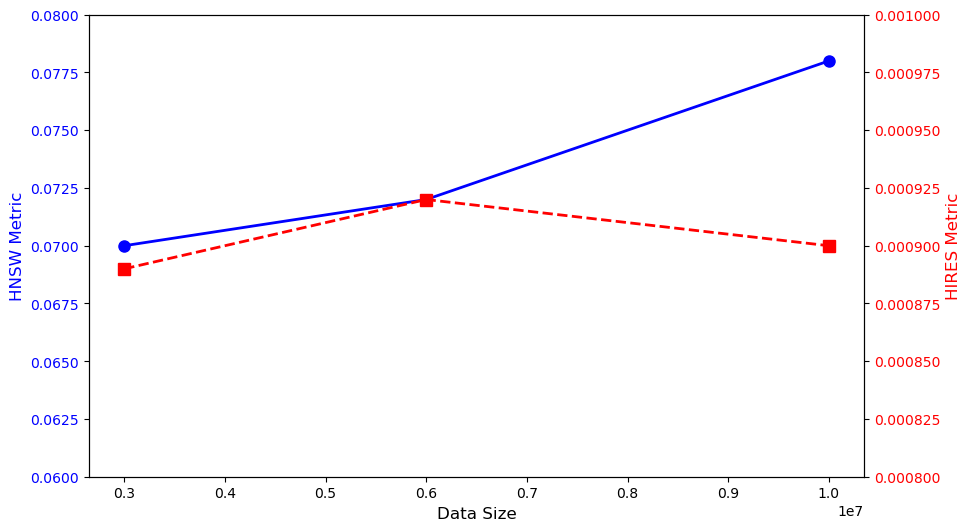

In [10]:
import matplotlib.pyplot as plt
import numpy as np

x = [3.0E+06, 6.0E+06, 1.0E+07]
y1 = [7.0E-02, 7.2E-02, 7.8E-02]  # HNSW
y2 = [8.9E-04, 9.2E-04, 9.0E-04]  # HIRES


fig, ax1 = plt.subplots(figsize=(10, 6))


ax1.plot(x, y1, 'b-o', linewidth=2, markersize=8, label='HNSW')
ax1.set_xlabel('Data Size', fontsize=12)
ax1.set_ylabel('HNSW Metric', color='b', fontsize=12)
ax1.tick_params(axis='y', labelcolor='b')


ax1.set_ylim(0.06, 0.08)


ax2 = ax1.twinx()
ax2.plot(x, y2, 'r--s', linewidth=2, markersize=8, label='HIRES')
ax2.set_ylabel('HIRES Metric', color='r', fontsize=12)
ax2.tick_params(axis='y', labelcolor='r')

ax2.set_ylim(0.0008, 0.001)  

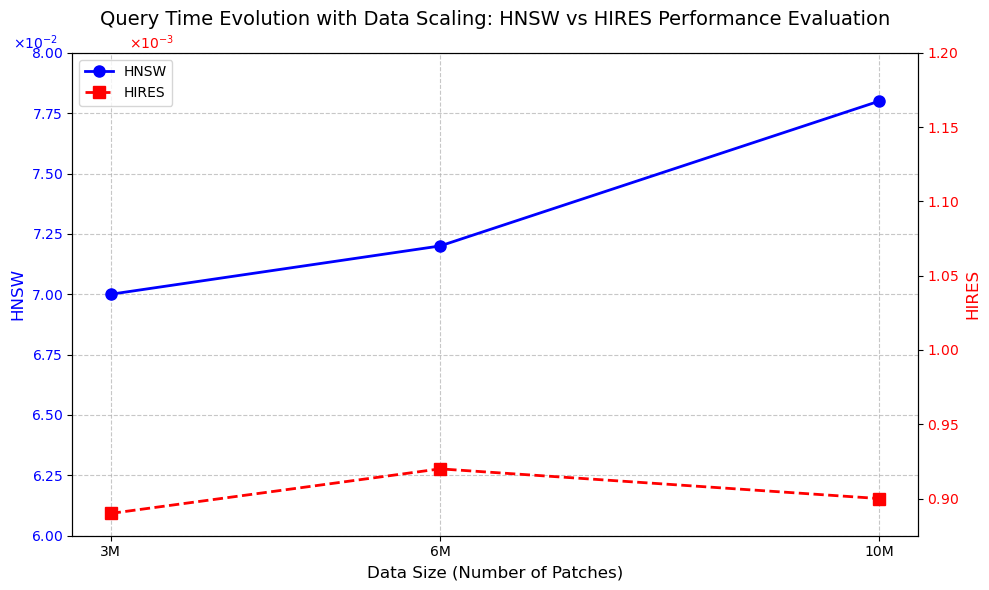

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter


x = [3.0E+06, 6.0E+06, 1.0E+07]
y1 = [7.0E-02, 7.2E-02, 7.8E-02]  # HNSW
y2 = [8.9E-04, 9.2E-04, 9.0E-04]  # HIRES

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(x, y1, 'b-o', linewidth=2, markersize=8, label='HNSW')
ax1.set_xlabel('Data Size (Number of Patches)', fontsize=12)
ax1.set_ylabel('HNSW', color='b', fontsize=12)

formatter_left = ScalarFormatter(useMathText=True)
formatter_left.set_powerlimits((-2, 2)) 
ax1.yaxis.set_major_formatter(formatter_left)
ax1.tick_params(axis='y', labelcolor='b')


ax1.set_ylim(0.06, 0.08)
ax2 = ax1.twinx()
ax2.plot(x, y2, 'r--s', linewidth=2, markersize=8, label='HIRES')
ax2.set_ylabel('HIRES', color='r', fontsize=12)


formatter_right = ScalarFormatter(useMathText=True)
formatter_right.set_powerlimits((-5,-4))
ax2.yaxis.set_major_formatter(formatter_right)
ax2.tick_params(axis='y', labelcolor='r')


ax2.set_ylim(0.000875, 0.0012)


ax1.set_xticks(x)
ax1.set_xticklabels(['3M', '6M', '10M'])
ax1.grid(linestyle='--', alpha=0.7)


ax1.yaxis.get_offset_text().set_position((-0.07, 0)) 
ax2.yaxis.get_offset_text().set_position((0.12, 0))  

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

plt.title('Query Time Evolution with Data Scaling: HNSW vs HIRES Performance Evaluation', fontsize=14, pad=20)
plt.tight_layout()
plt.show()